This example illustrates fitting and comparing two Machine Learning algorithms for classifying the binary target in the          
HMEQ data set. The steps include:                                    
                                                                      
1. PREPARE AND EXPLORE                                              
  a) Check data is loaded into CAS  
  <br>
2. PERFORM SUPERVISED LEARNING                                      
  a) Fit model using Logistic Regression                           
  b) Fit a model using a Decision Tree  
  <br>
3. EVALUATE AND IMPLEMENT                                         
  a) Score the data                                                
  b) Assess model performance                                      
  c) Generate ROC and Lift charts                                  

### Import packages

In [1]:
from swat import *
import pandas as pd
import matplotlib.pyplot as plt
from swat.render import render_html
%matplotlib inline

### CAS Server connection details

In [2]:
cashost='sasserver.demo.sas.com'
casport=5570
casauth='~/.authinfo'

### Start CAS session

In [3]:
sess = CAS(cashost, casport, authinfo=casauth, caslib="testuser")

### Import action sets

In [4]:
sess.loadactionset(actionset="sampling")
sess.loadactionset(actionset="regression")
sess.loadactionset(actionset="percentile")
sess.loadactionset(actionset="dataStep")
sess.loadactionset(actionset="decisionTree")

NOTE: Added action set 'sampling'.
NOTE: Added action set 'regression'.
NOTE: Added action set 'percentile'.
NOTE: Added action set 'dataStep'.
NOTE: Added action set 'decisionTree'.


[actionset]

 'decisionTree'

+ Elapsed: 0.00107s, sys: 0.002s, mem: 0.0297mb

### Set variables for input data

In [5]:
indata_dir         = "data"
indata             = "hmeq"
im_class_inputs    = "reason, job"
im_interval_inputs = "im_clage, clno, im_debtinc, loan, mortdue, value, im_yoj, im_ninq, derog, im_delinq"; 
target             = "bad"

### Load the data into CAS if needed               

In [6]:
if not sess.table.tableExists(table=indata).exists:
    sess.loadTable(caslib="casuser", path=indata_dir+"/"+indata+".sas7bdat", casout={"name":indata})

NOTE: Cloud Analytic Services made the file data/hmeq.sas7bdat available as table HMEQ in caslib CASUSER(viyauser).


### Impute missing values

In [7]:
# Pipelined imputation using transform action
sess.dataPreprocess.transform(
  table={"name":indata},
  casOut={"name":"hmeq_prepped", "replace":True},
  copyAllVars=True,
  outVarsNameGlobalPrefix="IM",
  requestPackages=[
    {"impute":{"method":"MEAN"}, "inputs":{"clage"}},
    {"impute":{"method":"MEDIAN"}, "inputs":{"delinq"}},
    {"impute":{"method":"RANDOM"}, "inputs":{"ninq"}},
    {"impute":{"method":"VALUE", "valuesContinuous":{50, 100}}, "inputs":{"debtinc", "yoj"}}
  ]
)

[TransInfo]

 Transformation Requests for HMEQ
 
   ActualName  NTransVars ImputeMethod          Seed
 0       _TR1           1         Mean           NaN
 1       _TR2           1       Median           NaN
 2       _TR3           1       Random  1.801404e+09
 3       _TR4           2        Value           NaN

[VarTransInfo]

 Variable Transformation Information for HMEQ
 
   Variable Transformation   ResultVar     N  NMiss  ImputedValueContinuous
 0    CLAGE             IM    IM_CLAGE  5652    308              179.766275
 1  DEBTINC             IM  IM_DEBTINC  4693   1267               50.000000
 2   DELINQ             IM   IM_DELINQ  5380    580                0.000000
 3     NINQ             IM     IM_NINQ  5450    510                     NaN
 4      YOJ             IM      IM_YOJ  5445    515              100.000000

[OutputCasTables]

               casLib          Name  Rows  Columns  \
 0  CASUSER(viyauser)  hmeq_prepped  5960       18   
 
                                             casTable  
 0  CASTable('hmeq_prepped', caslib='CASUSER(viyau...  

+ Elapsed: 0.0217s, user: 0.018s, sys: 0.007s, mem: 9.53mb

### Partition the data into training and validation

In [8]:
sess.sampling.stratified(
  table={"name":"hmeq_prepped", "groupBy":target},
  output={"casOut":{"name":"hmeq_part", "replace":True}, "copyVars":"ALL"},
  samppct=70,
  partind=True
)

NOTE: Using SEED=1453339403 for sampling.


[outputSize]

 {'outputNObs': 5960.0, 'outputNVars': 19}

[STRAFreq]

 Frequencies
 
    ByGrpID           BAD  NObs  NSamp
 0        0             0  4771   3340
 1        1             1  1189    832

[OutputCasTables]

               casLib       Name Label  Rows  Columns  \
 0  CASUSER(viyauser)  hmeq_part        5960       19   
 
                                             casTable  
 0  CASTable('hmeq_part', caslib='CASUSER(viyauser)')  

+ Elapsed: 0.0169s, user: 0.014s, sys: 0.005s, mem: 9.74mb

### LOGISTIC REGRESSION predictive model 

In [9]:
# ALL data used for training model 
lr = sess.regression.logistic(
  table={"name":"hmeq_part"},
  classVars=[{"vars":{"bad", "reason", "job"}}],
  model={
    "depVars":[{"name":target, "options":{"event":"1"}}],
    "effects":[{"vars":{"reason", "job", "im_clage", "clno", 
                        "im_debtinc", "loan", "mortdue", "value",
                        "im_yoj", "im_ninq", "derog", "im_delinq"}}]
  },
  selection={"method":"BACKWARD"},
  output={"casOut":{"name":"_scored_logistic", "replace":True}, "copyVars":"ALL"}
)

# Output model statistics
render_html(lr)

# Compute _pred0_ variable (1-_pred_)
sess.dataStep.runCode(
  code="data _scored_logistic; set _scored_logistic; _pred0_=1-_pred_; run;"
)

NOTE: Convergence criterion (GCONV=1E-8) satisfied.


Model Information 
 RowId 
 Description 
 Value 
 
 
 DATA Data Source HMEQ_PART 
 RESPONSEVAR Response Variable BAD 
 DIST Distribution Binary 
 LINK Link Function Logit 
 TECH Optimization Technique Newton-Raphson with Ridging 
 
 
 
 
 Number of Observations 
 RowId 
 Description 
 Value 
 
 
 NREAD Number of Observations Read 5960 
 NUSED Number of Observations Used 4609 
 
 
 
 
 Response Profile 
 Ordered Value 
 BAD 
 BAD 
 Total Frequency 
 Probability Modeled 
 
 
 1 0 0 3693 
 2 1 1 916 * 
 
 
 
 
 Class Level Information 
 Class 
 Levels 
 Values 
 
 
 JOB 6 Mgr Office Other ProfExe Sales Self 
 REASON 2 DebtCon HomeImp 
 
 
 
 
 Selection Information 
 Description 
 Value 
 Numeric Value 
 
 
 Selection Method Backward nan 
 Select Criterion SBC nan 
 Stop Criterion SBC nan 
 Effect Hierarchy Enforced Single nan 
 Stop Horizon 3 3 
 
 
 
 
 Convergence Status 
 Reason 
 Status 
 Max Gradient 
 
 
 Convergence criterion (GCONV=1E-8) satisfied. 0 0.0001342222 
 
 
 
 
 Selection Summary 
 Control 
 Step 
 Effect Removed 
 Number Of Effects 
 SBC 
 Optimal SBC 
 
 
 0 13 2960.9347561 0 
 - 1 REASON 12 2952.5146463 0 
 2 MORTDUE 11 2945.2975994 0 
 3 JOB 10 2940.6593135 0 
 4 IM_YOJ 9 2940.0820065 1 
 5 LOAN 8 2943.2942413 0 
 6 IM_NINQ 7 2953.1607122 0 
 7 CLNO 6 2962.6042144 0 
 
 
 
 
 Stop Reason 
 Reason 
 Code 
 
 
 Selection stopped at a local minimum of the STOP criterion. 6 
 
 
 
 
 Selection Reason 
 Reason 
 
 
 The model at step 4 is selected. 
 
 
 
 
 Selected Effects 
 Label 
 Effects 
 
 
 Selected Effects: Intercept LOAN IM_DELINQ VALUE IM_NINQ DEROG CLNO IM_CLAGE IM_DEBTINC 
 
 
 
 
 Dimensions 
 RowId 
 Description 
 Value 
 
 
 NDESIGNCOLS Columns in Design 9 
 NEFFECTS Number of Effects 9 
 MAXEFCOLS Max Effect Columns 1 
 DESIGNRANK Rank of Design 9 
 OPTPARM Parameters in Optimization 9 
 
 
 
 
 Likelihood Ratio Test 
 Test 
 DF 
 Chi-Square 
 Pr > ChiSq 
 
 
 Likelihood Ratio 8 1731.9273962 0 
 
 
 
 
 Fit Statistics 
 RowId 
 Description 
 Value 
 
 
 M2LL -2 Log Likelihood 2864.6554401 
 AIC AIC (smaller is better) 2882.6554401 
 AICC AICC (smaller is better) 2882.6945791 
 SBC SBC (smaller is better) 2940.5773359 
 
 
 
 
 Parameter Estimates 
 Effect 
 Parameter 
 Parameter 
 DF 
 Estimate 
 Standard Error 
 Chi-Square 
 Pr > ChiSq 
 
 
 Intercept Intercept Intercept 1 -7.075076036 0.3211972858 485.19742765 1.58055E-107 
 LOAN LOAN LOAN 1 -0.000016728 5.00913E-6 11.152671612 0.0008391074 
 IM_DELINQ IM_DELINQ IM_DELINQ 1 0.7335529238 0.0539912257 184.59355406 4.814256E-42 
 VALUE VALUE VALUE 1 1.2486229E-6 9.8022358E-7 1.6226031893 0.2027291917 
 IM_NINQ IM_NINQ IM_NINQ 1 0.1019104886 0.0231257363 19.419883954 0.0000104909 
 DEROG DEROG DEROG 1 0.6029766786 0.0696832197 74.876340784 5.011397E-18 
 CLNO CLNO CLNO 1 -0.022062449 0.0051319222 18.481929459 0.0000171523 
 IM_CLAGE IM_CLAGE IM_CLAGE 1 -0.005641 0.0007008935 64.775091816 8.395371E-16 
 IM_DEBTINC IM_DEBTINC IM_DEBTINC 1 0.1614953225 0.0065912835 600.31599416 1.42912E-132 
 
 
 
 
 Task Timing 
 RowId 
 Task 
 Time 
 Relative Time 
 
 
 SETUP Setup and Parsing 0.0027909279 0.017706022 
 LEVELIZATION Levelization 0.0056669712 0.0359520277 
 INITIALIZATION Model Initialization 0.0002920628 0.0018528854 
 SSCP SSCP Computation 0.0049870014 0.0316382079 
 FITTING Model Selection 0.1320807934 0.8379383208 
 OUTPUT Creating Output Data 0.0106470585 0.0675463713 
 CLEANUP Cleanup 0.0009989738 0.0063376245 
 TOTAL Total 0.1576259136 1 
 
 
 
 
 Output CAS Tables 
 CAS Library 
 Name 
 Label 
 Number of Rows 
 Number of Columns 
 Table 
 
 
 CASUSER(viyauser) _scored_logistic 5960 20 CASTable('_scored_logistic', caslib='CASUSER(viyauser)')

NOTE: Missing values were generated as a result of performing an operation on missing values.
      Each place is given by: (Number of times) at (Line):(Column).
      792 at 0:54


,casLib,Name,Rows,Columns,casTable
0,CASUSER(viyauser),_scored_logistic,5960,20,"CASTable('_scored_logistic', caslib='CASUSER(v..."
,casLib,Name,Rows,Columns,casTable
0,CASUSER(viyauser),_scored_logistic,5960,21,"CASTable('_scored_logistic', caslib='CASUSER(v..."


### Assess model performance (LOGISTIC REGRESSION) 

In [10]:
logitAssess=sess.percentile.assess(
  table={
    "name":"_scored_logistic", 
    "where": "strip(put(_partind_, best.))='0'"
  },
  inputs=[{"name":"_pred_"}],
  response="bad",
  event="1",
  pVar={"_pred0_"},
  pEvent={"0"}
)

logic_fitstat =logitAssess.FitStat
logit_rocinfo =logitAssess.ROCInfo
logit_liftinfo=logitAssess.LIFTInfo

### DECISION TREE predictive model

In [11]:
dt = sess.decisionTree.dtreeTrain(
  table={
    "name":"hmeq_part",
    "where":"strip(put(_partind_, best.))='1'"
  },
  inputs={"reason", "job", "im_clage", "clno", "im_debtinc", "loan", "mortdue", 
          "value", "im_yoj", "im_ninq", "derog", "im_delinq"},
  target="bad",
  nominals={"bad", "reason", "job"},
  crit="GAIN",
  prune=True,
  varImp=True,
  missing="USEINSEARCH",
  casOut={"name":"tree_model", "replace":True}
)

# Output model statistics
render_html(dt)

# Score 
sess.decisionTree.dtreeScore(
  table={"name":"hmeq_part"},
  modelTable={"name":"tree_model"},
  casOut={"name":"_scored_tree", "replace":True},
  copyVars={"bad", "_partind_"}
)

# Create p_bad0 and p_bad1 as _dt_predp_ is the probability of event in _dt_predname_
sess.dataStep.runCode(
  code="data _scored_tree; set _scored_tree; if _dt_predname_=1 then do; p_bad1=_dt_predp_; p_bad0=1-p_bad1; end; if _dt_predname_=0 then do; p_bad0=_dt_predp_; p_bad1=1-p_bad0; end; run;"
)

Decision Tree for HMEQ_PART 
 Descr 
 Value 
 
 
 Number of Tree Nodes 47 
 Max Number of Branches 2 
 Number of Levels 6 
 Number of Leaves 24 
 Number of Bins 20 
 Minimum Size of Leaves 5 
 Maximum Size of Leaves 1421 
 Number of Variables 12 
 Confidence Level for Pruning 0.25 
 Number of Observations Used 4172 
 Misclassification Error (%) 11.361457335 
 
 
 
 
 Decision Tree for HMEQ_PART 
 Analysis Variable 
 Importance 
 Std 
 Count 
 
 
 IM_DEBTINC 381.39071622 181.95807515 2 
 IM_DELINQ 86.017012141 30.667602281 3 
 DEROG 45.707438241 7.6203532926 4 
 CLNO 23.677699566 8.8664807603 2 
 JOB 18.852902333 3.2986870886 5 
 VALUE 15.778563854 0.5469241122 3 
 IM_NINQ 10.778392217 2.3384024578 2 
 MORTDUE 7.2144537981 0 1 
 REASON 0.6092916296 0 1 
 
 
 
 
 Output CAS Tables 
 CAS Library 
 Name 
 Number of Rows 
 Number of Columns 
 Table 
 
 
 CASUSER(viyauser) tree_model 47 40 CASTable('tree_model', caslib='CASUSER(viyauser)')

NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).
      0:39    0:108
NOTE: Duplicate messages output by DATA step:
NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).  (occurred 8 times)
      0:39    0:108  (occurred 8 times)


,casLib,Name,Rows,Columns,casTable
0,CASUSER(viyauser),_scored_tree,5960,14,"CASTable('_scored_tree', caslib='CASUSER(viyau..."
,casLib,Name,Rows,Columns,casTable
0,CASUSER(viyauser),_scored_tree,5960,16,"CASTable('_scored_tree', caslib='CASUSER(viyau..."


### Assess model performance (DECISION TREE) 

In [12]:
treeAssess=sess.percentile.assess(
  table={
    "name":"_scored_tree", 
    "where": "strip(put(_partind_, best.))='0'"               
  },
  inputs=[{"name":"p_bad1"}],  
  response="bad",
  event="1",
  pVar={"p_bad0"},
  pEvent={"0"}
)

tree_fitstat =treeAssess.FitStat
tree_rocinfo =treeAssess.ROCInfo
tree_liftinfo=treeAssess.LIFTInfo

### Create ROC and Lift plots (both models) using validation data

--------------------------AUC (using validation data)---------------------------


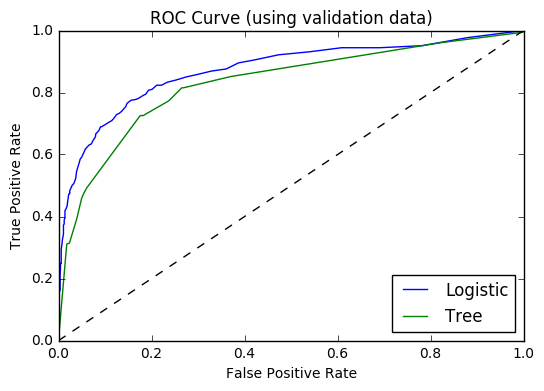

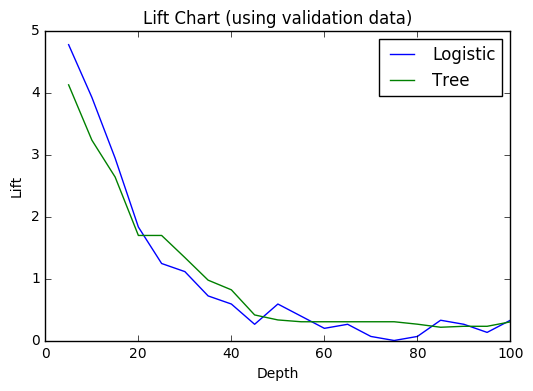

In [13]:
# Add new variable to indicate type of model
logit_liftinfo["model"]="Logistic"
logit_rocinfo["model"]="Logistic"
tree_liftinfo["model"]="Tree"
tree_rocinfo["model"]="Tree"

# Append data
all_liftinfo=logit_liftinfo.append(tree_liftinfo, ignore_index=True)
all_rocinfo=logit_rocinfo.append(tree_rocinfo, ignore_index=True)

#/* Print AUC (Area Under the ROC Curve) */
print("AUC (using validation data)".center(80, '-'))
all_rocinfo[["model", "C"]].drop_duplicates(keep="first").sort_values(by="C", ascending=False)

#/* Draw ROC charts */ 
plt.figure()
for key, grp in all_rocinfo.groupby(["model"]):
    plt.plot(grp["FPR"], grp["Sensitivity"], label=key)
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="best")
plt.title("ROC Curve (using validation data)")
plt.show()

#/* Draw lift charts */
plt.figure()
for key, grp in all_liftinfo.groupby(["model"]):
    plt.plot(grp["Depth"], grp["Lift"], label=key)
plt.xlabel("Depth")
plt.ylabel("Lift")
plt.legend(loc="best")
plt.title("Lift Chart (using validation data)")
plt.show()


### End CAS session

In [14]:
sess.close()